# Отток пользователей

**Задача**

Необходимо построить модель классификации и спрогнозировать, уйдет пользователь сайта или нет.

Необходимо развернутое решение с EDA, сравнением алгоритмов и т.д.,
какими-то инсайтами с комментариями в виде маркдаунов.

**План проекта**
1. Обзор данных
2. Предобработка
3. Обучение моделей
4. Тестирование моделей

## Обзор данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#!pip install sweetviz
import sweetviz as sv

#!pip install fast_ml
from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv('churn_dataset.csv')
data.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


Нам предоставлен датасет с данными по оттоку пользователей. Целевая переменная churn, бинарный флаг “отток / не отток”. 

## Предобработка

### Анализ данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

In [4]:
data.isna().sum().sort_values(ascending=False).head(45)

numbcars            49366
dwllsize            38308
HHstatin            37923
ownrent             33706
dwlltype            31909
lor                 30190
income              25436
adults              23019
infobase            22079
hnd_webcap          10189
prizm_social_one     7388
avg6rev              2839
avg6mou              2839
avg6qty              2839
ethnic               1732
rv                   1732
marital              1732
forgntvl             1732
kid0_2               1732
kid3_5               1732
kid6_10              1732
kid16_17             1732
creditcd             1732
truck                1732
kid11_15             1732
change_rev            891
change_mou            891
hnd_price             847
mou_Mean              357
rev_Mean              357
da_Mean               357
datovr_Mean           357
totmrc_Mean           357
ovrmou_Mean           357
ovrrev_Mean           357
vceovr_Mean           357
roam_Mean             357
area                   40
refurb_new  

В данных замечены следующие первичные проблемы:
1. Пропуски в данных
2. Дробные категориальные значения
3. Названия некоторых столбцов в верхнем регистре

In [5]:
#report = sv.analyze([data, "a"])
#report.show_html('common analysis.html')

### Обработка пропусков

**Проанализировав данные с помощью библиотеки Sweetviz мы можем заметить следующее:**

Пропуски в столбцах количества машин и тип жилья занимают 49% и 34% от всех данных, выделим их в отдельную категорию, так как у них практически  отсутствует зависимость от других признаков.

In [6]:
data['ownrent'].fillna('N', inplace=True)
data['numbcars'].fillna('0', inplace=True)

Признаки `dwllsize` и `dwlltype` взаимозависимы, поэтому заполним значения относительно имеющихся данных в этих столбцах.

In [7]:
data['dwlltype'].fillna('none', inplace=True)
data['dwllsize'].fillna('none', inplace=True)

data.loc[(data['dwllsize'] == 'none')&(data['dwlltype'] == 'S'), 'dwllsize'] = 'A'
data.loc[(data['dwllsize'] == 'none')&(data['dwlltype'] == 'M'), 'dwllsize'] = 'B'

# в строках, где отсутствуют оба значения, выделим пропуски в отдельную категорию.

data.loc[data['dwlltype'] == 'none', 'dwlltype'] = 'None'
data.loc[data['dwllsize'] == 'none', 'dwllsize'] = 'None'

In [8]:
# исследуем следующую категорию пропусков
data.loc[(data['infobase'].isna() ==True)]['HHstatin']

22       NaN
29       NaN
42       NaN
49       NaN
55       NaN
        ... 
99972    NaN
99974    NaN
99980    NaN
99983    NaN
99998    NaN
Name: HHstatin, Length: 22079, dtype: object

Предположительно: так как в большинстве случаев, пропуски встречаются в одних и тех же строках, в столбце `infobase` информация о том, есть ли данные о пользователе или их нет. Если данных нет - указано значение N или пропуск, которые соответствуют пропускам в столбцах `adults`, `income`, `HHstatin`. Так как в данных строках отсутствует сразу несколько признаков, удалим их.

In [9]:
data.dropna(subset = ['infobase'], inplace = True)

index = data.loc[(data['infobase'] == 'N')]['income']
data.drop(index=(index.index), inplace=True)

Cтолбцы `avg6mou`, `avg6qty`, `avg6rev` коррелируются со значениями в столбцах `avg3mou`, `avg3qty`, `avg3rev` - средняя разница между значениями по всем строкам низка, поэтому можем заполнить пропуски в столбцах  `avg6mou`... значениями из соответствующих стобцов.

In [10]:
dif = [(data['avg6mou'] - data['avg3mou']).mean(), (data['avg6qty'] - data['avg3qty']).mean(), 
       (data['avg6rev'] - data['avg3rev']).mean()]
print ('Средняя разница значений в столбцах: ', dif)

Средняя разница значений в столбцах:  [-6.825489808034831, -1.3649449172108978, -0.3975987861996174]


In [11]:
data['avg6mou'].fillna(data['avg3mou'], inplace=True)
data['avg6qty'].fillna(data['avg3qty'], inplace=True)
data['avg6rev'].fillna(data['avg3rev'], inplace=True)

В столбце `hnd_webcap` 2 категории: `WCMB` - 80% и `WC` - 15%, заполним соответсвенно процентному соотношению.

In [12]:
data['hnd_webcap'].fillna('WCMB', limit=8500, inplace=True)
data['hnd_webcap'].fillna('WC', inplace=True)

In [13]:
# пропуски в столбце `prizm_social_one` выделим в отдельную категорию
data['prizm_social_one'].fillna('N', inplace=True)

# оставшиеся пропуски `HHstatin` выделим в отдельную категорию
data['HHstatin'].fillna('None', inplace=True)

In [14]:
# пропуски в столбце `area` менее 1%, заменим самым часто встречающимся значением
data['area'].fillna('NEW YORK CITY AREA', inplace=True)

# пропуски в `lor` заменим на предыдущее значение, так как данные распределены равномерно
data['lor'].fillna(method="ffill", inplace=True)

In [15]:
# для красоты заменим оставшиеся пропуски средними и медианой, так как их менее 1%
median = ['income', 'adults']
mean = ['change_mou', 'hnd_price', 'change_rev', 'ovrrev_Mean', 'vceovr_Mean','datovr_Mean', 
        'roam_Mean', 'ovrmou_Mean', 'da_Mean', 'mou_Mean', 'totmrc_Mean', 'rev_Mean']
for i in median:
    data[i].fillna(data[i].median(), inplace=True)

for i in mean:
    data[i].fillna(data[i].mean(), inplace=True)


In [16]:
# проверим, все ли пропуски заполнены
data.isna().sum().sort_values(ascending=False).head()

rev_Mean      0
avgqty        0
refurb_new    0
dualband      0
area          0
dtype: int64

### Обработка данных

In [17]:
# приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [18]:
# удалим столбец с ID пользователя, мы сможем его найти по индексу
data = data.drop('customer_id', axis=1)

In [19]:
# заменим категориальные значения на целочисленные
cats = ['forgntvl', 'eqpdays', 'numbcars', 'adults', 'lor', 'rv', 'truck', 'models', 'phones']

data[cats] = data[cats].astype('int', errors='ignore')

### Анализ аномальных значений

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77697 entries, 0 to 99999
Data columns (total 99 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev_mean          77697 non-null  float64
 1   mou_mean          77697 non-null  float64
 2   totmrc_mean       77697 non-null  float64
 3   da_mean           77697 non-null  float64
 4   ovrmou_mean       77697 non-null  float64
 5   ovrrev_mean       77697 non-null  float64
 6   vceovr_mean       77697 non-null  float64
 7   datovr_mean       77697 non-null  float64
 8   roam_mean         77697 non-null  float64
 9   change_mou        77697 non-null  float64
 10  change_rev        77697 non-null  float64
 11  drop_vce_mean     77697 non-null  float64
 12  drop_dat_mean     77697 non-null  float64
 13  blck_vce_mean     77697 non-null  float64
 14  blck_dat_mean     77697 non-null  float64
 15  unan_vce_mean     77697 non-null  float64
 16  unan_dat_mean     77697 non-null  float6

In [21]:
data.describe()

,rev_mean,mou_mean,totmrc_mean,da_mean,ovrmou_mean,ovrrev_mean,vceovr_mean,datovr_mean,roam_mean,change_mou,...,phones,models,truck,rv,lor,adults,income,numbcars,forgntvl,eqpdays
count,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,...,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000,77697.000000
mean,56.952165,480.535758,45.158623,0.843956,38.900639,12.777618,12.537166,0.237695,1.236215,-11.898379,...,1.788409,1.546881,0.238812,0.104444,6.164614,2.525439,5.791858,1.021558,0.073323,406.172104
std,45.388809,504.344378,23.328964,2.127358,94.391558,29.283454,28.957005,2.821456,15.674610,265.107325,...,1.316768,0.902183,0.426361,0.305838,4.731776,1.446997,2.138109,0.901508,0.260668,263.915685
min,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-5.000000
25%,32.490000,137.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-78.250000,...,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,4.000000,0.000000,0.000000,218.000000
50%,45.980000,327.750000,44.990000,0.247500,2.000000,0.700000,0.350000,0.000000,0.000000,-6.250000,...,1.000000,1.000000,0.000000,0.000000,5.000000,2.000000,6.000000,1.000000,0.000000,354.000000
75%,67.715000,648.750000,57.652500,0.742500,38.900639,12.962500,12.600000,0.000000,0.235000,57.500000,...,2.000000,2.000000,0.000000,0.000000,9.000000,3.000000,7.000000,2.000000,0.000000,559.000000
max,3843.262500,12206.750000,399.990000,159.390000,4320.750000,896.087500,896.087500,423.540000,3685.200000,31219.250000,...,28.000000,16.000000,1.000000,1.000000,15.000000,6.000000,9.000000,3.000000,1.000000,1823.000000


Посмотрим на распределение данных вокруг среднего в столбцах со средними значениями Mean.

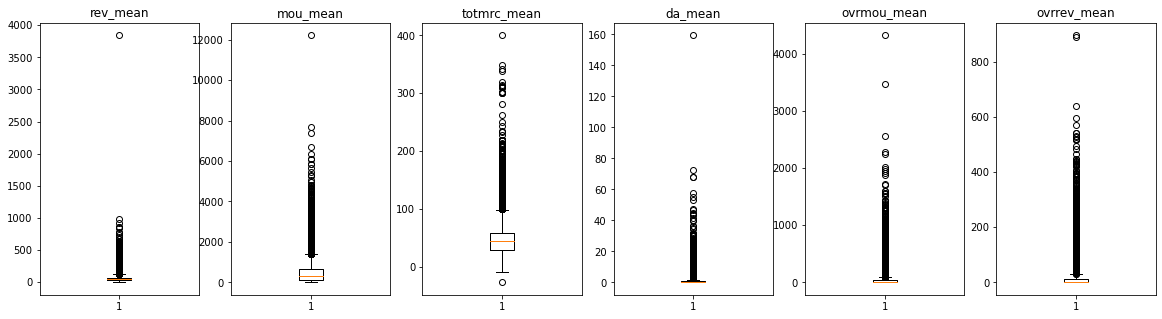

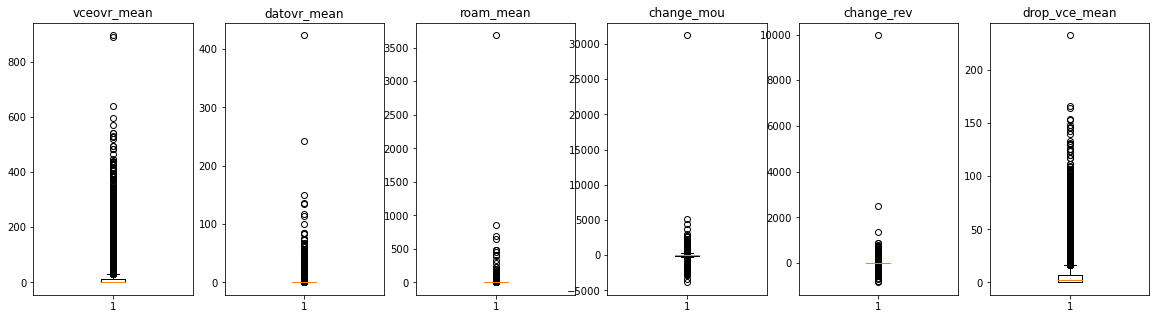

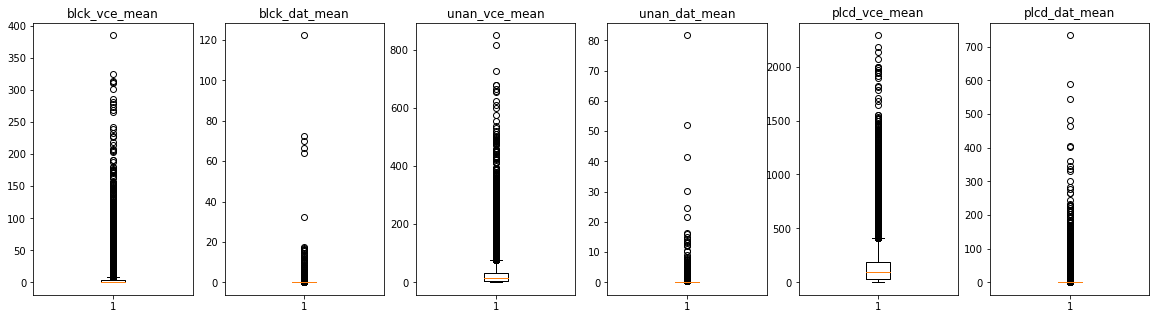

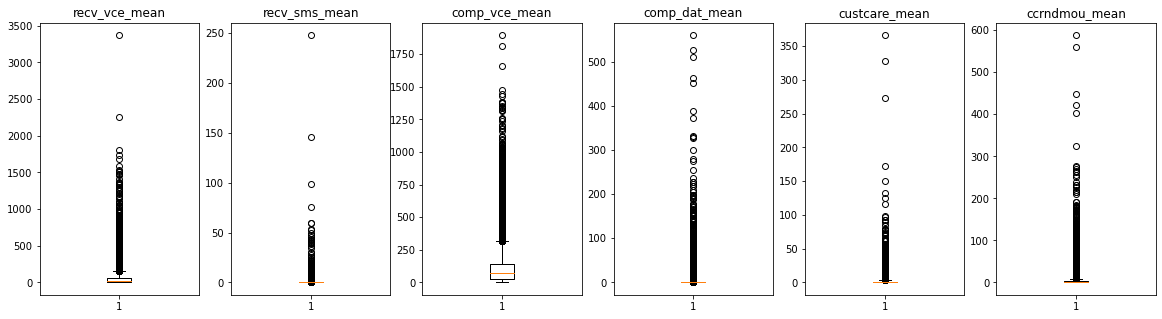

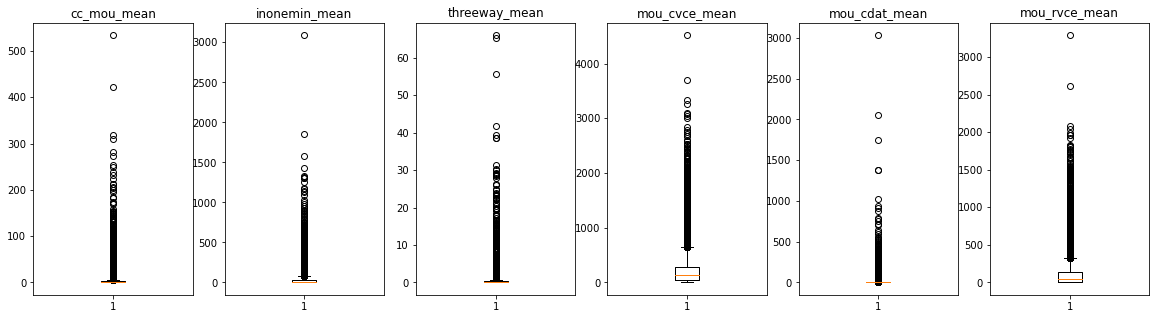

In [22]:
# создадим список по 6 признаков
row1 = list(data.columns[0:6])
row2 = list(data.columns[6:13])
row3 = list(data.columns[13:19])
row4 = list(data.columns[19:25])
row5 = list(data.columns[25:31])
row = [row1, row2, row3, row4, row5]

# цикл для построения диграмм
for r in row:
    figure, ax = plt.subplots(1, 6, figsize=(20, 5))
    for i in range(6):
        ax[i].boxplot(data[r[i]])
        ax[i].set(title=r[i])
    

Так как данных у нас достаточно много, много и аномалий, удалим их.

In [23]:
# список с аномальными значениями
rows = list(data.columns[:30])
distinct = [1000, 4000, 200, 20, 1000, 100, 
            100, 50, 500, 5000, 2000, 100, 
            100, 20, 200, 10, 700, 100, 
            500, 50, 500, 100, 50, 100, 
            100, 500, 10, 1000, 500, 1000]

# цикл для удаления аномалий
for row in range(len(rows)):
    data = data[(data[rows[row]] < distinct[row])]

Исследуем аномалии в других столбцах.

In [24]:
row = ['totcalls', 'totmou', 'totrev', 'adjrev', 'adjqty', 'eqpdays']

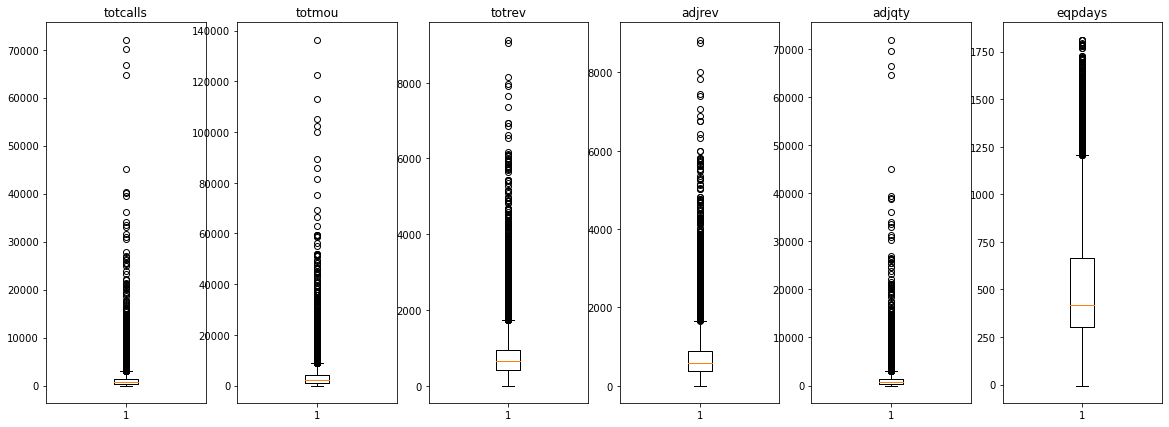

In [25]:
figure, ax = plt.subplots(1, 6, figsize=(20, 7))

# функция для построения диграмм
for i in range(6):
    ax[i].boxplot(data[row[i]])
    ax[i].set(title=row[i])

In [26]:
# удалим аномалии
rows = list(data[row])

distinct = [20000, 40000, 3000, 3000, 10000, 1500]

for row in range(len(rows)):
    data = data[(data[rows[row]] < distinct[row])]
    
data.shape

(24468, 99)

Мы удалили по возможности аномальные значения.

### Подготовка признаков

**Кодировка**

Подготовим отдельный датасет с численными признаками для моделей, которые не обучаются на категориальных данных.

In [27]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.columns

Index(['rev_mean', 'mou_mean', 'totmrc_mean', 'da_mean', 'ovrmou_mean',
       'ovrrev_mean', 'vceovr_mean', 'datovr_mean', 'roam_mean', 'change_mou',
       ...
       'ethnic_S', 'ethnic_U', 'ethnic_X', 'ethnic_Z', 'kid0_2_Y', 'kid3_5_Y',
       'kid6_10_Y', 'kid11_15_Y', 'kid16_17_Y', 'creditcd_Y'],
      dtype='object', length=206)

In [28]:
encoder = OrdinalEncoder()
category = ['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband', 'refurb_new', 
            'hnd_webcap', 'ownrent', 'dwlltype', 'marital', 'infobase', 'hhstatin', 'dwllsize',
           'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd']

data[category] = encoder.fit_transform(data[category])
data.shape

(24468, 99)

**Разделение на выборки**

Разделим данные для кросс-валидации на тренировочную и тестовую: 75% и 25% соответственно

In [29]:
features = data.drop('churn', axis=1)
target = data['churn']

# разделение 25:75
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print ('Размер обучающей выборки: ', features_train.shape)
print ('Размер тестовой выборки: ', features_test.shape)

Размер обучающей выборки:  (18351, 98)
Размер тестовой выборки:  (6117, 98)


**Значимость признаков**

Проанализируем признаки, которые наиболее важны при моделировании

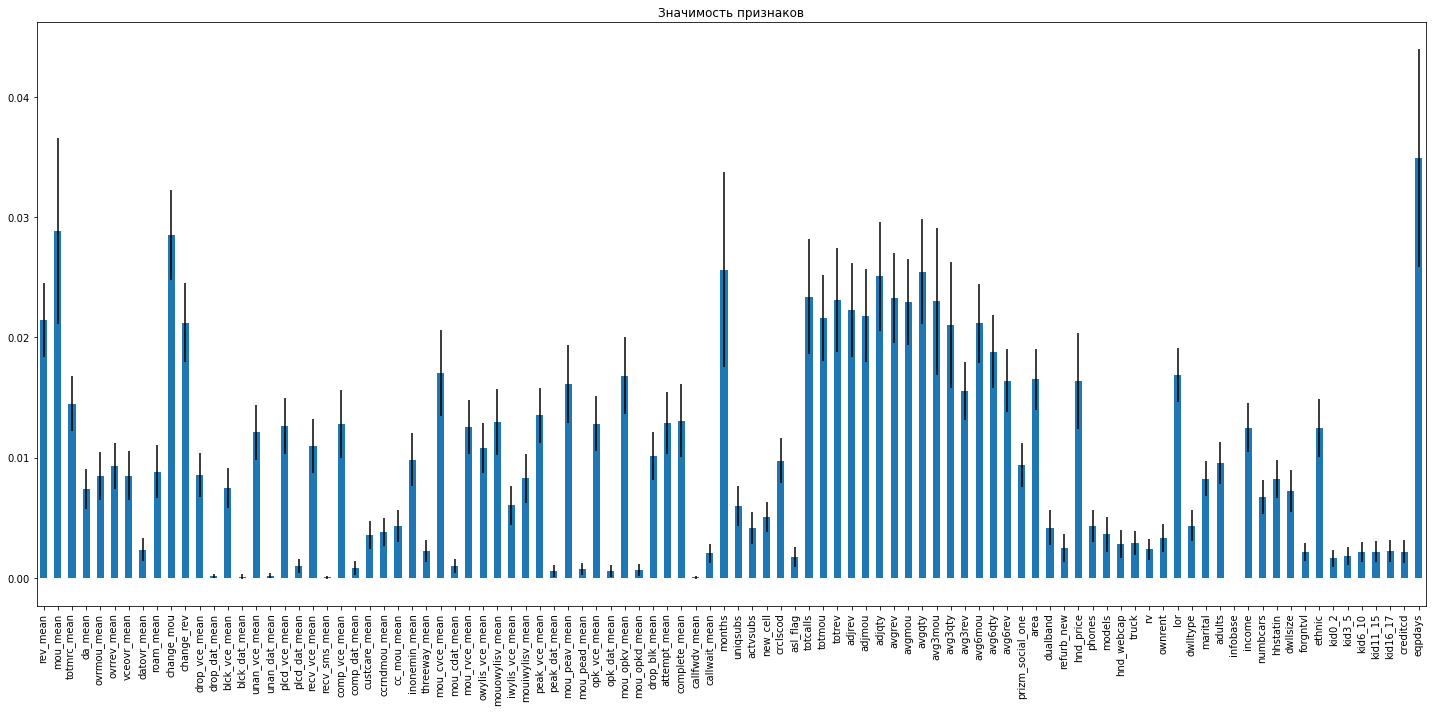

In [30]:
feature_names = features_train.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(features_train, target_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Значимость признаков")
fig.tight_layout()

Оставим только те признаки, значимость которых более 0.001.

In [31]:
importances = forest_importances[forest_importances > 0.001]
features_train = features_train[list(importances.index)]
features_test = features_test[list(importances.index)]

**Масштабирование признаков**

Стандартизируем численные признаки датасета.

In [32]:
# создадим список категоризированных данных
category = ['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband', 'refurb_new', 
            'hnd_webcap', 'ownrent', 'dwlltype', 'marital', 'infobase', 'hhstatin', 'dwllsize',
           'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd', 'phones', 
            'models', 'truck', 'rv', 'lor', 'adults', 'income', 'numbcars', 'forgntvl', 'uniqsubs',
           'actvsubs', '']

# функция для стандартизации численных признаков
def scaler(features_train, features_test):
    numeric = list(features_train.columns) #[i for i in list(features_train.columns) if i not in category]
    
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_test

features_train, features_test = scaler(features_train, features_test)

features_train.head()

,rev_mean,mou_mean,totmrc_mean,da_mean,ovrmou_mean,ovrrev_mean,vceovr_mean,datovr_mean,roam_mean,change_mou,...,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
99988,1.044031,1.487213,0.562188,0.765514,1.195468,1.116773,1.111223,0.163202,0.150373,-0.110297,...,-0.286338,-0.31138,-1.183723,-0.238032,-0.258566,-0.338546,-0.344614,-0.352675,-2.773632,-1.526099
21302,-0.005603,-0.576159,-0.291530,-0.366634,-0.332247,-0.338745,-0.333970,-0.076801,0.546085,0.040886,...,2.400690,-0.31138,-0.624542,-0.238032,-0.258566,-0.338546,-0.344614,-0.352675,0.360538,-0.986453
67116,-0.306208,-0.115230,0.271289,-0.366634,-0.332247,-0.338745,-0.333970,-0.076801,-0.185540,0.320466,...,-0.493032,-0.31138,-0.065361,-0.238032,-0.258566,-0.338546,-0.344614,-0.352675,0.360538,-0.765524
66618,-1.128730,-0.565762,-1.416604,-0.366634,-0.332247,-0.338745,-0.333970,-0.076801,-0.185540,0.199687,...,0.540440,-0.31138,-0.065361,-0.238032,-0.258566,-0.338546,-0.344614,-0.352675,-2.773632,-1.689079
22493,0.931242,0.961427,0.834670,-0.034618,-0.332247,-0.338745,-0.333970,-0.076801,0.024369,1.125657,...,1.780607,-0.31138,-0.065361,-0.238032,-0.258566,-0.338546,-0.344614,-0.352675,-2.773632,-1.124081


### Вывод:

Данные загружены и подготовлены:
* Обработаны пропуски
* Обработаны названия столбцов
* Удалены неинформативные признаки
* Обработаны аномалии
* Данные стандартизированы
* Данные разделены на выборки и подготовлены к обучению моделей

## Обучение моделей

**Дерево решений**

Обучим модель дерева решений и проведем кросс-валидацию с помощью GridSearch

In [33]:
# features_train, target_train, features_test, target_test
# зададим параметры для модели

#parameters_tree = { 'max_depth': range (1, 15, 2), 'random_state' : [12345] }
parameters_tree = { 'max_depth': range (1,13, 2), 'min_samples_leaf' : range (1, 3), 'min_samples_split' : range (2, 4)}

In [34]:
# переберем гиперпараметры и проведем кросс-валидацию
model_tree = DecisionTreeClassifier()

grid_tree = GridSearchCV(model_tree, param_grid = parameters_tree, scoring = 'roc_auc', cv=4)

# обучим модели
grid_tree.fit(features_train, target_train)

# определим лучшую модель
print ('По модели дерева решений лучший результат: ', grid_tree.best_score_)
print('Лучшие параметры модели: ', grid_tree.best_params_)

По модели дерева решений лучший результат:  0.6397935670266677
Лучшие параметры модели:  {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3}


Результат дерева решений - 0.63, обучим другие модели.

**Случайный лес**

Для случайного леса создадим функцию, которая переберет параметры для целевого признака и проведет кросс-валидацию

In [35]:
# напишем цикл для перебора параметров случайного леса

model_forest = 0
best_score = 0
    
for depth in range(1, 10):
    for est in range(30, 41, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        scores = cross_val_score(model, features_train, target_train, cv=4, scoring = 'roc_auc')
               
        score = pd.Series(scores).mean()
        if score > best_score:
            best_score = score
            model_forest = model
                

print('Лучшие параметры модели: ', model_forest)
print ('По модели случайного леса лучший результат: ', best_score)

Лучшие параметры модели:  RandomForestClassifier(max_depth=9, n_estimators=40, random_state=12345)
По модели случайного леса лучший результат:  0.6768237234710386


**Логистическая регрессия**

In [36]:
# обучим логистическую регрессию и оценим качество кросс-валидацией

lg_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)

scores = cross_val_score(lg_model, features_train, target_train, cv=4, scoring = 'roc_auc')

print ('Результат логистической регрессии:', scores.mean())

Результат логистической регрессии: 0.6460333401272935


**Наивный байесовский алгоритм**

In [37]:
gnb_model = GaussianNB()

scores = cross_val_score(gnb_model, features_train, target_train, cv=4, scoring = 'roc_auc')

display ('Результат Naive Bayes classifier:', scores.mean())

'Результат Naive Bayes classifier:'

0.5927397837177405

Наилучший результат показала модель Random Forest. Протестируем ее.

## Тестирование модели

Проверим модель на тестовой выборке.

In [38]:
model_forest.fit(features_train, target_train)
predictions_test = model_forest.predict(features_test)

print ('AUC-ROC модели на тестовой выборке: ', roc_auc_score(predictions_test, target_test))

AUC-ROC модели на тестовой выборке:  0.6186667523281036


Проверим модель на адекватность - сравним с константной моделью DummyRegressor.

In [39]:
model = DummyClassifier(strategy="most_frequent")
model.fit(features_train, target_train)
prediction_dumm = model.predict(features_test)

print ('AUC-ROC константной модели: ', roc_auc_score(target_test, prediction_dumm))

AUC-ROC константной модели:  0.5


## Вывод


Модель прошла тестирование и показала результат AUC-ROC 0.6. Наиболее удачная обученная модель - модель Random Forest с глубиной равной 3. Данная модель поможет предсказать уйдёт клиент в ближайшее время или нет.

В исследовании оттока пользователей для поставленной задачи: построить модель классификации и спрогнозировать, уйдет пользователь сайта или нет, было выполнено следующее:

1. Подготовленны данные:
* Изучена csv таблица
* Обработаны пропуски и аномалии
* Закодированы данные с помощью техники OHE и OE
* Разделены на выборки: тренировочную и тестовую
* Стандартизированы

2. Обучено и оценено несколько моделей:
* DecisionTree
* RandomForest
* LogisticRegression
* GaussianNB

3. Модель протестирована:
* Результат тестирования показал эффективность и адекватность модели за счет примерно равных значений метрик AUC-ROC тестовой и тренировочной выборки.